In [234]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr
import json

In [235]:
movie_df = pd.read_csv('cache/data.csv', sep=',', index_col=0)

# Countries with Oscar nominations

In [ ]:
country_df = movie_df.copy()
# Convert the strings in movie_df (currently on the format ['A', 'B']) to lists with json.loads. Json.loads requires double quotation marks, so we first replace to fix this.
# TODO: Move this into data preprocessing?
country_df['countries'] = country_df['countries'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

In [237]:
# All rows with Oscar nominations
oscar_nominated_df = country_df[country_df['oscar_nominated'] == True]

# The column 'countries' contains a list of countries for each row. We explode the df on this list, so that we get a single row for each actor/country pair
# If a movie is from multiple countries, we count the Oscar nominations for all those countries.
exploded_df = oscar_nominated_df.explode(column='countries').rename(columns={'countries':'country'}).reset_index()

We plot the 10 countries with the most nominations:

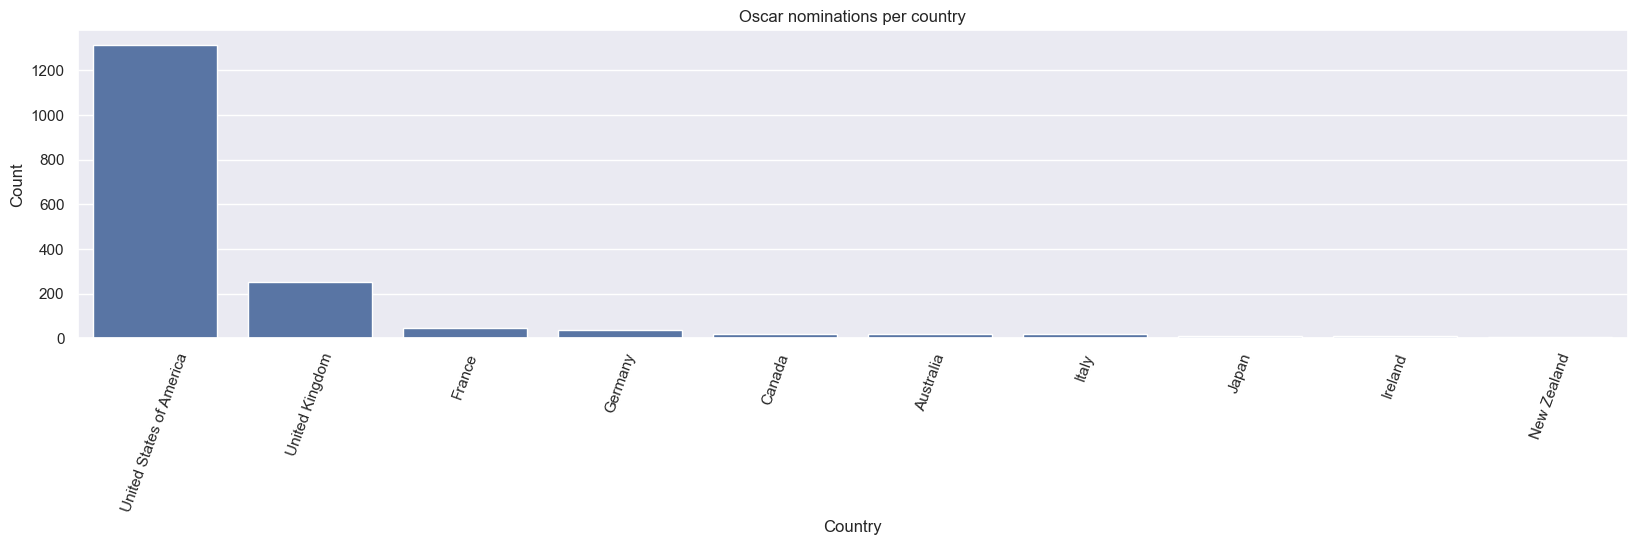

In [238]:
sns.set_theme(rc={'figure.figsize':(20, 4)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Oscar nominations per country')
sns.countplot(x='country', data=exploded_df, order=exploded_df['country'].value_counts()[:10].index);

We see that the USA is vastly overrepresented. We combine all countries other than the USA and UK into an "others" category

In [239]:
exploded_df['country'] = exploded_df['country'].apply(lambda country: country if country in ['United States of America', 'United Kingdom'] else 'Others')

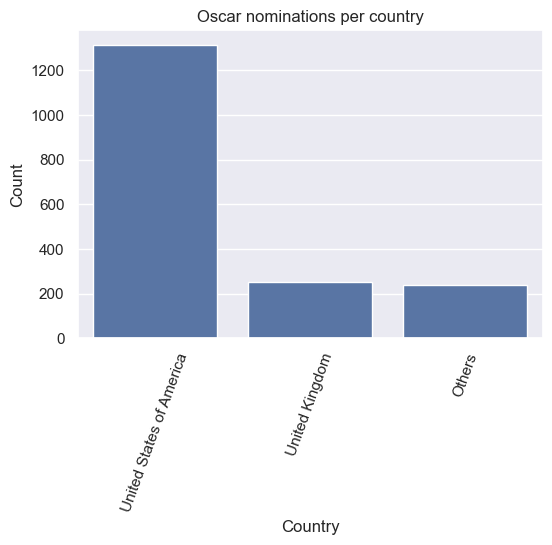

In [240]:
sns.set_theme(rc={'figure.figsize':(6, 4)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Oscar nominations per country')
sns.countplot(x='country', data=exploded_df, order=exploded_df['country'].value_counts()[:10].index);

# Binomial analysis USA vs. non-USA

In [241]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# All actors/movie rows, American and non-American
total_actors_num = len(movie_df['countries'])
american_total_actors_num = len(movie_df[movie_df['countries'].str.contains('United States of America')])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(movie_df[movie_df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(movie_df[(movie_df['countries'].str.contains('United States of America')) & (movie_df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [242]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

# We perform a two-sided hypothesis test for whether non-American actors have the same binomial probability of getting nominated as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

BinomTestResult(k=130, n=203152, alternative='two-sided', statistic=0.0006399149405371347, pvalue=2.6118071094409342e-307)

Using alpha=0.05. P-value=2.6118071094409342e-307 < 0.05. We can safely discard the null hypothesis that these have the same probability distribution, and conclude that there is a significantly different probability of being nominated for an Oscar for American and non-American actors.

In [243]:
print('Fraction of American actors nominated for an Oscar:',round(p_american, 5))
print('Fraction of non-American actors nominated for an Oscar:', round(p_non_american, 5))

Fraction of American actors nominated for an Oscar: 0.00546
Fraction of non-American actors nominated for an Oscar: 0.00064


We see that the observed probability of being nominated is higher for actors in American movies. We believe based on this analysis that the Oscar nominations are generally skewed with higher chances for actors in American movies.